# 한글설정

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False
plt.rc('font', family='NanumGothicCoding')

# 데이터 가져오기

In [2]:
import os
import gdown

id = "10Hpa4YM0KX_Ig0W9w7DbTdq62nF2UThA"
output = "./open.zip"

if not os.path.isdir('./datasets'):
  gdown.download(id=id, output=output)
  gdown.extractall(path=output, to='./datasets')

# 데이터프레임 만들기

In [3]:
import os
import glob
import pandas as pd
from collections import defaultdict

raw_data = defaultdict(pd.DataFrame)

for fname in glob.glob('./**/*.csv', recursive=True):
    df_name = os.path.splitext(os.path.basename(fname))[0]
    raw_data[df_name] = pd.read_csv(fname)

* 정상(Normal)과 불량(Error) 데이터 분리

In [4]:
train = raw_data['train'].copy()
train['Status'] = 'Normal'
for idx, val in raw_data['y_feature_spec_info'].iterrows():
    train.loc[(train[val['Feature']] < val['최소']) | (train[val['Feature']] > val['최대']), ['Status']] = 'Error'

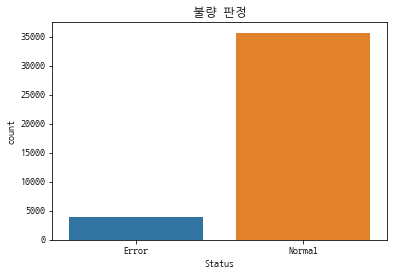

In [5]:
import seaborn as sns

sns.countplot(x='Status', data=train)
plt.title('불량 판정')
plt.show()

# 평가함수

In [59]:
import numpy as np
from sklearn import metrics

# 데이콘에서 제공한 평가함수
def lg_nrmse(gt, preds):
    # 각 Y Feature별 NRMSE 총합
    # Y_01 ~ Y_08 까지 20% 가중치 부여
    # gt = gt.to_numpy()
    all_nrmse = []
    for idx in range(0,14): # ignore 'ID'
        rmse = metrics.mean_squared_error(gt[:,idx], preds[:,idx], squared=False)
        nrmse = rmse/np.mean(np.abs(gt[:,idx]))
        all_nrmse.append(nrmse)
    score = 1.2 * np.sum(all_nrmse[:8]) + 1.0 * np.sum(all_nrmse[8:14])
    return score

* 평가함수에서 가중치를 제외

In [7]:
def except_nrmse(gt, preds):
    # 각 Y Feature별 NRMSE 총합
    all_nrmse = []
    for idx in range(len(gt)): # ignore 'ID'
        rmse = metrics.mean_squared_error(gt[:,idx], preds[:,idx], squared=False)
        nrmse = rmse/np.mean(np.abs(gt[:,idx]))
        all_nrmse.append(nrmse)
    score = np.sum(all_nrmse)
    return score

# 

## 가중치 1.2를 가진 Y값에 대한 Feature Selection

In [66]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression


X = train.filter(regex='X').drop(columns=['X_04', 'X_23', 'X_47', 'X_48'])
result = np.zeros(len(X))

for i in range(14):

    y = train.filter(items=[f'Y_{i+1:02d}']).values.ravel() #[ f'Y_{i+1:02d}' for i in range(8) ]
    mi = mutual_info_regression(X, y, discrete_features='auto'
                                    , n_neighbors=3, copy=True, random_state=13)

    mi = (1.2 if i < 8 else 1) * mi
    if i == 0:
        result = mi
    else:
        result += mi

In [91]:
result_df = pd.DataFrame(index=X.columns, data=result)
result_df.head()

,0
X_01,0.040506
X_02,0.014407
X_03,0.142101
X_05,0.086015
X_06,0.036350


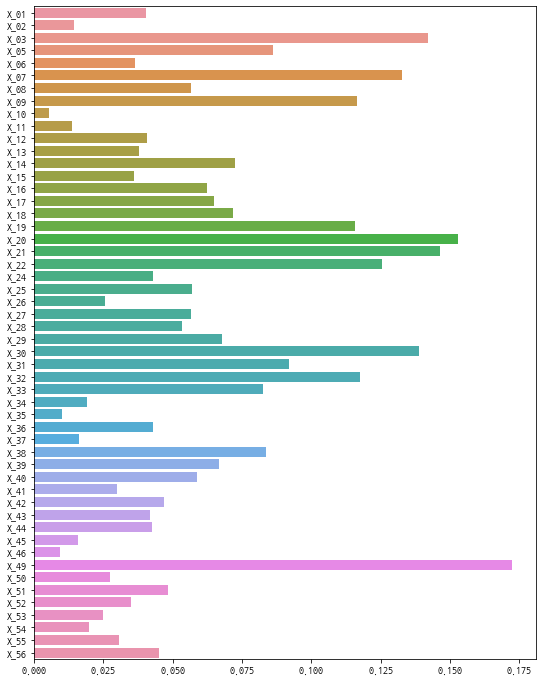

In [80]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(9,12))
sns.barplot(y=X.columns, x=result, ax=ax)
plt.show()

## SelectFromModel

In [96]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor

X = train.filter(regex='X').drop(columns=['X_04', 'X_23', 'X_47', 'X_48'])
# y = train.filter(regex='Y')
y = train.filter(items=[ f'Y_{i+1:02d}' for i in range(8) ])

selector = SelectFromModel(estimator=RandomForestRegressor(n_estimators=200), max_features=10).fit(X, y)


In [93]:
selector.threshold_

0.019230769230769235

In [97]:
selected_columns = X.columns
selected_columns[selector.get_support()]

Index(['X_03', 'X_05', 'X_07', 'X_08', 'X_09', 'X_49', 'X_51', 'X_52', 'X_53',
       'X_56'],
      dtype='object')

In [101]:
y = train.filter(items=[ f'Y_{i+1:02d}' for i in range(8) ])

selector = SelectFromModel(estimator=RandomForestRegressor(n_estimators=400, n_jobs=-1), max_features=40).fit(X, y)

selected_columns = X.columns
selected_columns[selector.get_support()]

Index(['X_03', 'X_05', 'X_07', 'X_08', 'X_09', 'X_19', 'X_20', 'X_21', 'X_22',
       'X_34', 'X_37', 'X_49', 'X_50', 'X_51', 'X_52', 'X_53', 'X_54', 'X_55',
       'X_56'],
      dtype='object')

In [102]:
y = train.filter(items=[ f'Y_{i+1:02d}' for i in range(8, 14) ])

selector = SelectFromModel(estimator=RandomForestRegressor(n_estimators=400, n_jobs=-1), max_features=40).fit(X, y)

selected_columns = X.columns
selected_columns[selector.get_support()]

Index(['X_03', 'X_05', 'X_07', 'X_08', 'X_09', 'X_19', 'X_20', 'X_21', 'X_22',
       'X_35', 'X_49', 'X_50', 'X_51', 'X_52', 'X_53', 'X_54', 'X_55', 'X_56'],
      dtype='object')

In [103]:
selector. feature_importances_ 

AttributeError: 'SelectFromModel' object has no attribute 'feature_importances_'

In [95]:
selector.transform(X)

array([[ 67.47    , 101.892   ,  29.45    , ..., 147.837968, 134.313475,
        125.028256],
       [ 65.17    , 101.944   ,  28.73    , ..., 149.924692, 123.630583,
        124.877308],
       [ 64.07    , 103.153   ,  28.81    , ..., 146.814592, 128.93907 ,
        122.238232],
       ...,
       [ 64.67    , 103.144   ,  29.96    , ..., 134.419328, 129.115431,
        119.166699],
       [ 63.67    , 102.025   ,  30.3     , ..., 141.288011, 130.141676,
        124.525929],
       [ 65.67    , 102.004   ,  30.16    , ..., 142.019357, 123.752157,
        136.714504]])

In [ ]:


# X_train, y_train, X_test, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

# selector = SelectKBest(score_func=mutual_info_regression)

# X_trian_sel = selector.fit(X_train, y_train)
# X_test_set = selector.transform(X_test)

# # select 된 feature 확인
# all_col = X_train.columns
# all_col[selector.get_support()]
# # get_support() : select feature=True, Unselect feature=False로 반환

# # selected feature 들의 영향력(score)을 확인
# df_score = pd.DataFrame(selector.scores_,
# 						selector.feature_names_in_)
# df_score                        


In [27]:
def get_outlier(df=None, column=None, weight=1.5, status='Error'):
    fraud = df[df['Status'] == status][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)

    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight

    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index

    return outlier_index

def remove_outlier(df, columns, status, weight, max_limit=40000):
    outlier_list = []

    for colname in columns: 
        outlier = get_outlier(df, colname, weight=weight, status=status)
        if len(outlier) > max_limit:
            continue
        outlier_list.extend(outlier)

    result = df.drop(outlier_list, axis=0).copy()

    return result

# 학습하기

In [82]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

scaler_list = [
    ('Unscaled', None),
    ('Standard', StandardScaler()),
    ('Min-Max', MinMaxScaler()),
    ('Min-Abs', MaxAbsScaler()),
    ('Robust', RobustScaler(quantile_range=(25, 75))),
    ('uniform pdf', QuantileTransformer(output_distribution="uniform")),
    ('gaussian pdf', QuantileTransformer(output_distribution="normal")),
    ('L2 normalizing', Normalizer())
]

In [83]:
import time
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold

def run_train(scaler=None):

  kf = KFold(shuffle=True, random_state=13)
  loss = []
  
  # 데이터 나누기
  X, y = train.filter(regex='X').values, train.filter(regex='Y').values
  for train_index, test_index in kf.split(X):
    since = time.time()
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # 파이프라인 작성
    pipe = make_pipeline( 
      scaler[1], 
      RandomForestRegressor(criterion="squared_error", random_state=13, n_jobs=-1, n_estimators=200)
    )

    # 학습하기
    pipe.fit(X_train, y_train)

    # 검증하기
    y_pred = pipe.predict(X_test)

    # 평가 및 기록
    elapsed = time.time() - since
    result = lg_nrmse(y_test, y_pred)
    print("Loss: {:.4f}, Elapsed Time: {:.2f}".format(result, elapsed))
    loss.append(result)
  print("{}, Best: {:.4f}, Avg:{:.4f}".format(scaler[0], min(loss), np.mean(loss)))

  return pipe[1], result

In [86]:
best_loss = 15

for scaler in scaler_list:
    model, result = run_train(scaler=scaler)
    if result < best_loss:
        best_loss = result
        best_model = model
        


# 결과파일 작성

In [ ]:
def make_summit(model):
  test = raw_data['test'].drop(columns=['ID']).copy()

  test = apply_scaler(test)

  preds = model.predict(test)
  print('Done.')

  submit = raw_data['sample_submission'].copy()
  for idx, col in enumerate(submit.columns):
    if col=='ID':
        continue
    submit[col] = preds[:,idx-1]
  print('Done.')

  submit.to_csv('/content/submit.csv', index=False)
  print('Done.')

make_summit(best_model)

Done.
Done.
Done.
